# BitFEAR: Time Series Analysis

Experimental analysis and learning using:

* Tweets containing #bitcoin, with Vader sentiment scores
* Tweet volume for #bitcoin
* Google Trends data
* Deribit Bitcoin Options orderbook data
* Bitcoin price data

In [3]:
%config IPCompleter.greedy=True

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [5]:
plt.rcParams["figure.figsize"] = (16, 10)

### Getting tweets from Google Cloud Storage

In [6]:
from google.cloud import firestore
import json

In [7]:
db = firestore.Client()
tweets_ref = db.collection('tweet_data_#bitcoin')

tweets = list()
tweet_docs = list()
#for doc in tweets_ref.stream():
#    tweets.append(doc.to_dict())
    
def count_collection(coll_ref, count, cursor=None):

    if cursor is not None:
        docs = [snapshot for snapshot
                in coll_ref.limit(1000).order_by("__name__").start_after(cursor).stream()]
    else:
        docs = [snapshot for snapshot
                in coll_ref.limit(1000).order_by("__name__").stream()]

    count = count + len(docs)
    tweet_docs.append(docs)

    if len(docs) == 1000:
        return count_collection(coll_ref, count, docs[999].reference.get())
    else:
        print(count)

In [6]:
# ONLY RUN THIS CELL TO RETREIVE TWEETS FROM THE BEGINNING (EXPENSIVE!)

count_collection(tweets_ref, 0)
last_tweet = tweet_docs[-1][-1].reference.get()

430384


In [153]:
# Get tweets since last retreival

count_collection(tweets_ref, 0, last_tweet)
last_tweet = tweet_docs[-1][-1].reference.get()

60986


In [7]:
tweets += [item.to_dict() for sublist in tweet_docs for item in sublist]

In [8]:
tweets_df = pd.DataFrame(tweets)
tweets_df['compound'] = pd.json_normalize(tweets_df['sentiment_scores'])['compound']
tweets_df = tweets_df.filter(['created', 'tweet_id', 'user_id', 'compound'])

In [10]:
#tweets_df = tweets_df.drop_duplicates().reset_index(drop=True)
tweets_df

,created,tweet_id,user_id,compound
0,2020-03-09 19:43:06+00:00,1237101627925987329,116270443,0.0000
1,2020-03-09 19:43:20+00:00,1237101685757087744,2372242398,0.4926
2,2020-03-09 19:43:26+00:00,1237101710935392256,1075804135524585473,0.4926
3,2020-03-09 19:43:30+00:00,1237101728488718336,877210351301001216,0.0000
4,2020-03-09 19:43:32+00:00,1237101736650661888,1153377427034259457,0.4019
...,...,...,...,...
430379,2020-05-11 17:08:22+00:00,1259893121086824455,628352957,-0.2263
430380,2020-05-11 17:08:24+00:00,1259893127793577984,1246430585150676995,0.0000
430381,2020-05-11 17:08:38+00:00,1259893189130911753,136770654,0.0000
430382,2020-05-11 17:08:39+00:00,1259893192763285506,898520034716385280,0.7424


In [9]:
# Backup
tweets_df.to_csv('tweets.csv', index=False)

In [11]:
# Load from backup
tweets_df = pd.read_csv('tweets.csv')
tweets_df['created'] = pd.to_datetime(tweets_df['created'])
tweets_df

,created,tweet_id,user_id,compound
0,2020-03-09 19:43:06+00:00,1237101627925987329,116270443,0.0000
1,2020-03-09 19:43:20+00:00,1237101685757087744,2372242398,0.4926
2,2020-03-09 19:43:26+00:00,1237101710935392256,1075804135524585473,0.4926
3,2020-03-09 19:43:30+00:00,1237101728488718336,877210351301001216,0.0000
4,2020-03-09 19:43:32+00:00,1237101736650661888,1153377427034259457,0.4019
...,...,...,...,...
430379,2020-05-11 17:08:22+00:00,1259893121086824455,628352957,-0.2263
430380,2020-05-11 17:08:24+00:00,1259893127793577984,1246430585150676995,0.0000
430381,2020-05-11 17:08:38+00:00,1259893189130911753,136770654,0.0000
430382,2020-05-11 17:08:39+00:00,1259893192763285506,898520034716385280,0.7424


### Calculate tweet volume

In [19]:
tweets_time_df = tweets_df.set_index('created').filter(['tweet_id', 'compound'])
tweets_time_df

,tweet_id,compound
created,,
2020-03-09 19:43:06+00:00,1237101627925987329,0.0000
2020-03-09 19:43:20+00:00,1237101685757087744,0.4926
2020-03-09 19:43:26+00:00,1237101710935392256,0.4926
2020-03-09 19:43:30+00:00,1237101728488718336,0.0000
2020-03-09 19:43:32+00:00,1237101736650661888,0.4019
...,...,...
2020-05-11 17:08:22+00:00,1259893121086824455,-0.2263
2020-05-11 17:08:24+00:00,1259893127793577984,0.0000
2020-05-11 17:08:38+00:00,1259893189130911753,0.0000


In [20]:
tweet_grouped = tweets_time_df.groupby(pd.Grouper(freq='5Min'))
tweet_volume = tweet_grouped.count()
tweet_volume

,tweet_id,compound
created,,
2020-03-09 19:40:00+00:00,13,13
2020-03-09 19:45:00+00:00,29,29
2020-03-09 19:50:00+00:00,30,30
2020-03-09 19:55:00+00:00,40,40
2020-03-09 20:00:00+00:00,40,40
...,...,...
2020-05-11 16:45:00+00:00,101,101
2020-05-11 16:50:00+00:00,111,111
2020-05-11 16:55:00+00:00,101,101


Text(0.5, 1.0, '#bitcoin Tweets per 5 min')

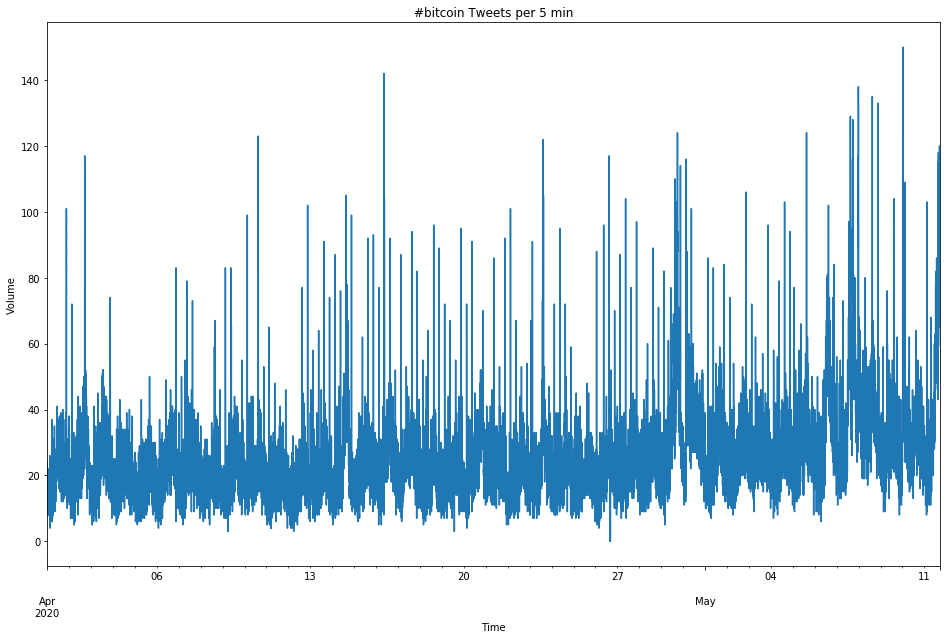

In [21]:
plot_start_date = '2020-04-01'

ax = tweet_volume['tweet_id'].loc[plot_start_date:].plot()
ax.set_xlabel('Time')
ax.set_ylabel('Volume')
ax.set_title('#bitcoin Tweets per 5 min')

Investigate the spikes:

In [22]:
tweet_volume.sort_values(by='tweet_id')

,tweet_id,compound
created,,
2020-03-10 23:50:00+00:00,0,0
2020-03-10 22:40:00+00:00,0,0
2020-03-10 22:45:00+00:00,0,0
2020-03-10 20:40:00+00:00,0,0
2020-03-10 20:35:00+00:00,0,0
...,...,...
2020-03-13 00:00:00+00:00,142,142
2020-04-16 08:30:00+00:00,142,142
2020-03-12 11:00:00+00:00,149,149


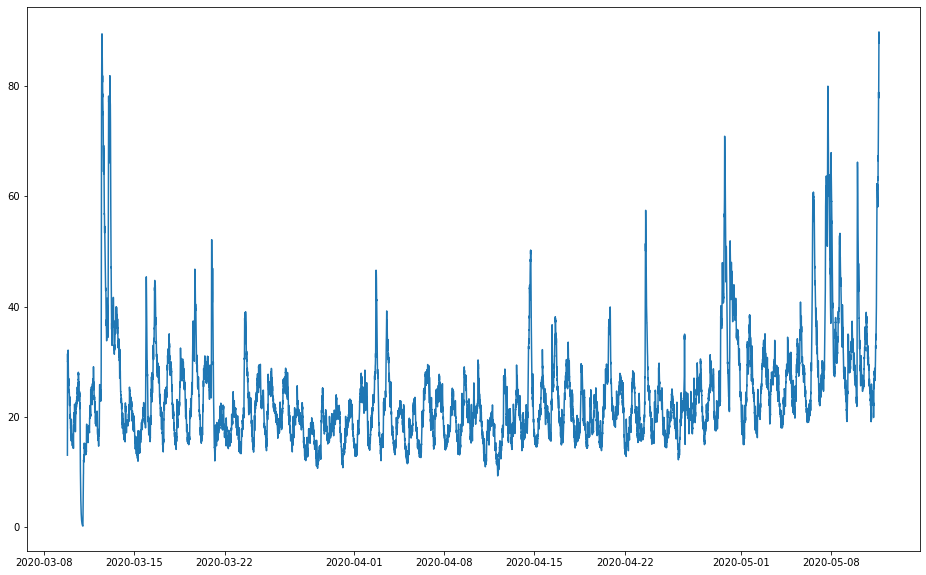

In [23]:
tweet_volume['smooth'] = tweet_volume['tweet_id'].ewm(12).mean()
plt.plot(tweet_volume['smooth'])

### Tweet sentiment time series

In [24]:
sentiment_time = tweet_grouped.mean()
sentiment_time

,tweet_id,compound
created,,
2020-03-09 19:40:00+00:00,1.237102e+18,0.261085
2020-03-09 19:45:00+00:00,1.237103e+18,0.194479
2020-03-09 19:50:00+00:00,1.237104e+18,0.176573
2020-03-09 19:55:00+00:00,1.237105e+18,0.081617
2020-03-09 20:00:00+00:00,1.237106e+18,0.050008
...,...,...
2020-05-11 16:45:00+00:00,1.259888e+18,0.036684
2020-05-11 16:50:00+00:00,1.259889e+18,0.031877
2020-05-11 16:55:00+00:00,1.259890e+18,0.089107


Text(0, 0.5, 'Mean Sentiment Rating')

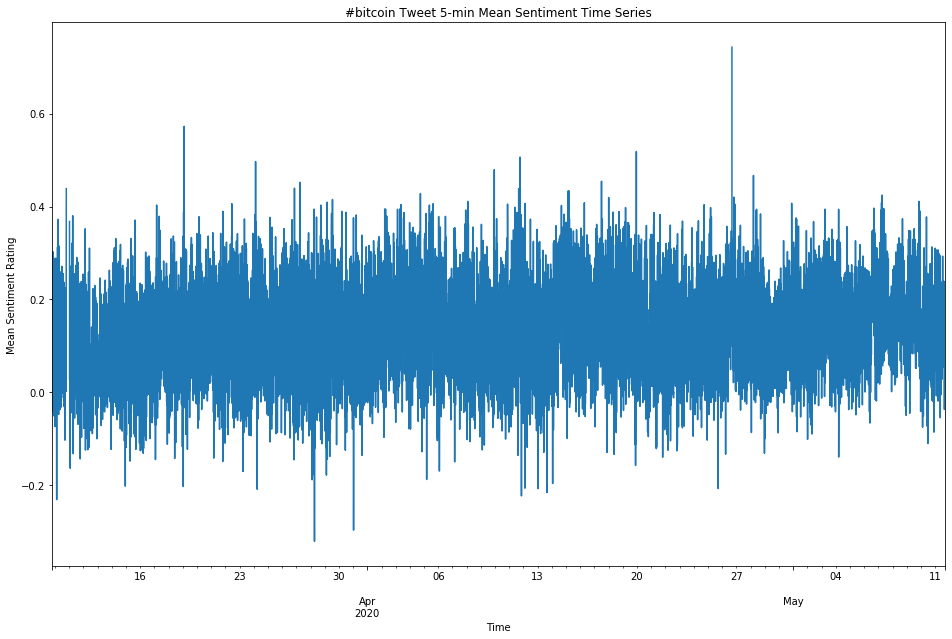

In [25]:
sentiment_time['compound'].plot()
plt.title('#bitcoin Tweet 5-min Mean Sentiment Time Series')
plt.xlabel('Time')
plt.ylabel('Mean Sentiment Rating')

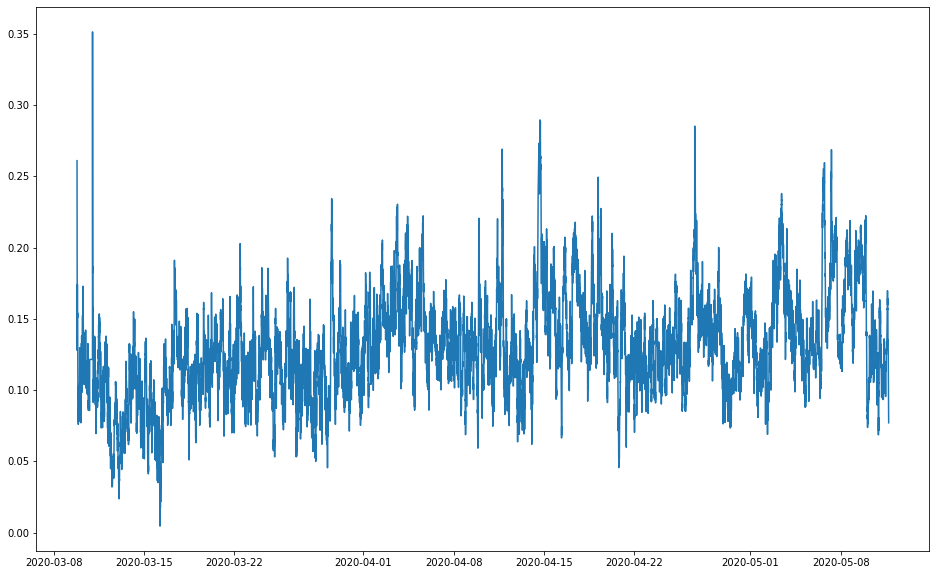

In [26]:
sentiment_time['smooth'] = sentiment_time['compound'].ewm(12).mean()
plt.plot(sentiment_time['smooth'])

### Google Trends Data

In [27]:
from pytrends.request import TrendReq

In [20]:
focus_words = ['bitcoin']

pygt = TrendReq()
pygt.build_payload(kw_list=focus_words)

interest_over_time_df = pygt.interest_over_time()
del interest_over_time_df['isPartial']
interest_over_time_df

,bitcoin
date,
2015-05-17,2
2015-05-24,2
2015-05-31,2
2015-06-07,2
2015-06-14,2
...,...
2020-04-05,13
2020-04-12,12
2020-04-19,12


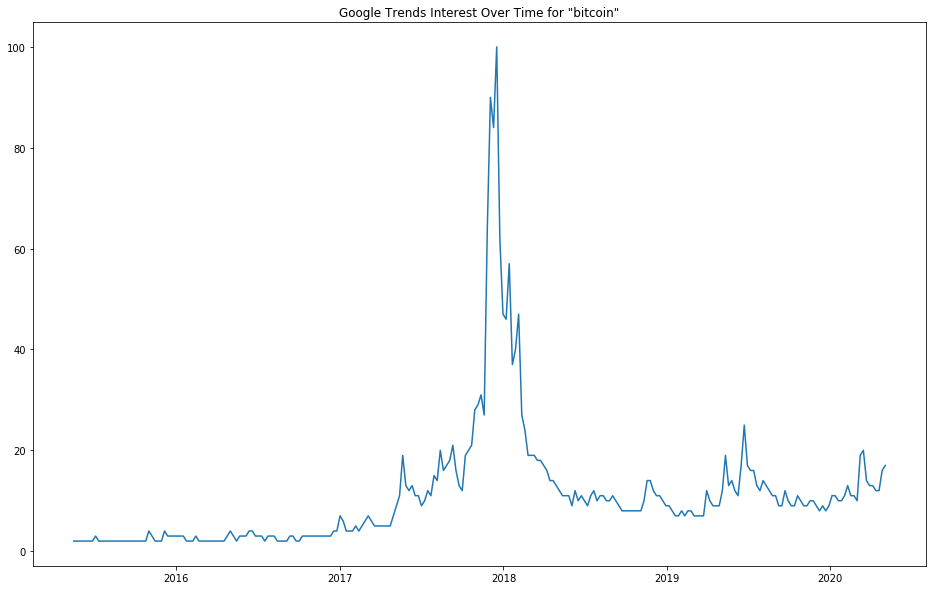

In [21]:
plot = plt.plot(interest_over_time_df)
plt.title('Google Trends Interest Over Time for "bitcoin"')
plt.show()

In [33]:
historical_hourly_interest_df = pygt.get_historical_interest(focus_words, year_start=2020, month_start=4, day_start=17, hour_start=0, year_end=2020, month_end=5, day_end=11, hour_end=0, cat=0, geo='', gprop='').drop('isPartial', axis=1).reset_index().drop_duplicates('date').set_index('date')
historical_hourly_interest_df

The request failed: Google returned a response with code 500.


,bitcoin
date,
2020-04-17 00:00:00,80
2020-04-17 01:00:00,76
2020-04-17 02:00:00,77
2020-04-17 03:00:00,77
2020-04-17 04:00:00,82
...,...
2020-05-10 20:00:00,73
2020-05-10 21:00:00,72
2020-05-10 22:00:00,70


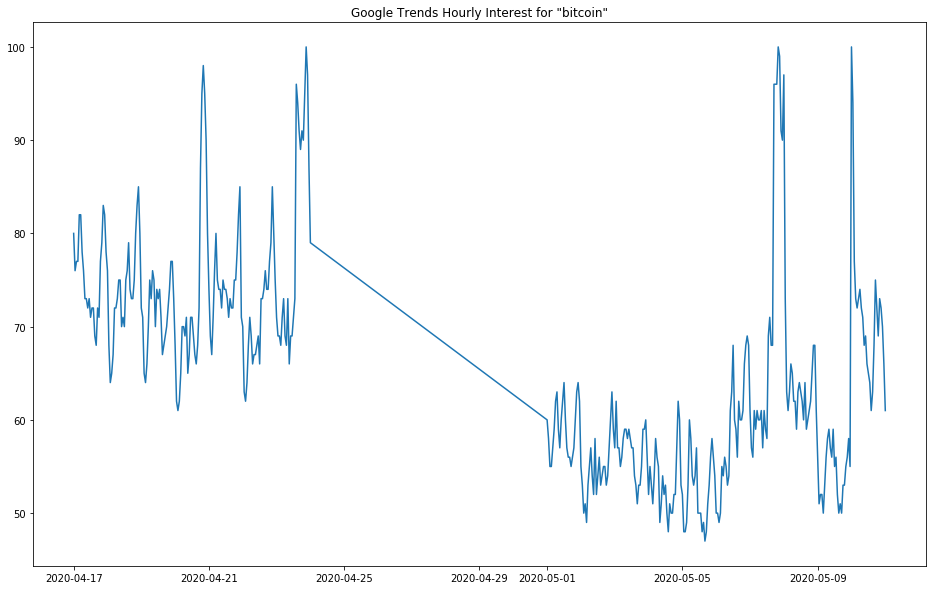

In [34]:
plot = plt.plot(historical_hourly_interest_df)
plt.title('Google Trends Hourly Interest for "bitcoin"')
plt.show()

In [61]:
rq = requests.get('https://trends.google.com/trends/api/widgetdata/multiline?hl=en-GB&tz=-60&req=%7B%22time%22:%222020-05-02T17%5C%5C:04%5C%5C:57+2020-05-05T17%5C%5C:04%5C%5C:57%22,%22resolution%22:%22EIGHT_MINUTE%22,%22locale%22:%22en-GB%22,%22comparisonItem%22:%5B%7B%22geo%22:%7B%7D,%22complexKeywordsRestriction%22:%7B%22keyword%22:%5B%7B%22type%22:%22BROAD%22,%22value%22:%22bitcoin%22%7D%5D%7D%7D%5D,%22requestOptions%22:%7B%22property%22:%22%22,%22backend%22:%22CM%22,%22category%22:0%7D%7D&token=APP6_UEAAAAAXrLuOb-aOlX32UFLI6M5qP76vAS0v6mG&tz=-60')

In [62]:
print(rq.content.decode())

<!DOCTYPE html><html lang=en><meta charset=utf-8><meta name=viewport content="initial-scale=1, minimum-scale=1, width=device-width"><title>Error 401 (Not Found)!!1</title><style nonce="VpEXry9oLDmibunv/+32nw">*{margin:0;padding:0}html,code{font:15px/22px arial,sans-serif}html{background:#fff;color:#222;padding:15px}body{color:#222;text-align:unset;margin:7% auto 0;max-width:390px;min-height:180px;padding:30px 0 15px;}* > body{background:url(//www.google.com/images/errors/robot.png) 100% 5px no-repeat;padding-right:205px}p{margin:11px 0 22px;overflow:hidden}pre{white-space:pre-wrap;}ins{color:#777;text-decoration:none}a img{border:0}@media screen and (max-width:772px){body{background:none;margin-top:0;max-width:none;padding-right:0}}#logo{background:url(//www.google.com/images/branding/googlelogo/1x/googlelogo_color_150x54dp.png) no-repeat;margin-left:-5px}@media only screen and (min-resolution:192dpi){#logo{background:url(//www.google.com/images/branding/googlelogo/2x/googlelogo_color_

Some issues with this data.

Upsample with linear interpolation to five minute intervals to match other data series.

In [35]:
gtrend_5min_df = pd.DataFrame(historical_hourly_interest_df.bitcoin.resample('5min').interpolate(method='linear'))
gtrend_5min_df.index = gtrend_5min_df.index.tz_localize('UTC')
gtrend_5min_df

,bitcoin
date,
2020-04-17 00:00:00+00:00,80.000000
2020-04-17 00:05:00+00:00,79.666667
2020-04-17 00:10:00+00:00,79.333333
2020-04-17 00:15:00+00:00,79.000000
2020-04-17 00:20:00+00:00,78.666667
...,...
2020-05-10 23:40:00+00:00,62.666667
2020-05-10 23:45:00+00:00,62.250000
2020-05-10 23:50:00+00:00,61.833333


### Bitcoin price index data

In [28]:
import requests
from io import StringIO

In [29]:
btc_index_dbit_data_1 = requests.get('https://www.deribit.com/static/csv/2020-04_btc_usd_price_index.csv').content.decode()
btc_index_dbit_data_2 = requests.get('https://www.deribit.com/static/csv/2020-05_btc_usd_price_index.csv').content.decode()

In [30]:
btc_index_dbit_df = pd.read_csv(StringIO(btc_index_dbit_data_1), skiprows=1).append(pd.read_csv(StringIO(btc_index_dbit_data_2), skiprows=1))
btc_index_dbit_df['Date and Time'] = pd.to_datetime(btc_index_dbit_df['Date and Time'], format='%Y-%m-%d %H:%M:%S')
btc_index_dbit_df = btc_index_dbit_df.set_index('Date and Time').tz_localize('UTC', level=0)
btc_index_dbit_df

,Price
Date and Time,
2020-04-01 00:00:00+00:00,6423.38
2020-04-01 00:00:01+00:00,6423.79
2020-04-01 00:00:02+00:00,6423.72
2020-04-01 00:00:03+00:00,6423.88
2020-04-01 00:00:04+00:00,6424.28
...,...
2020-05-12 22:00:29+00:00,8753.22
2020-05-12 22:00:30+00:00,8754.64
2020-05-12 22:00:31+00:00,8755.65


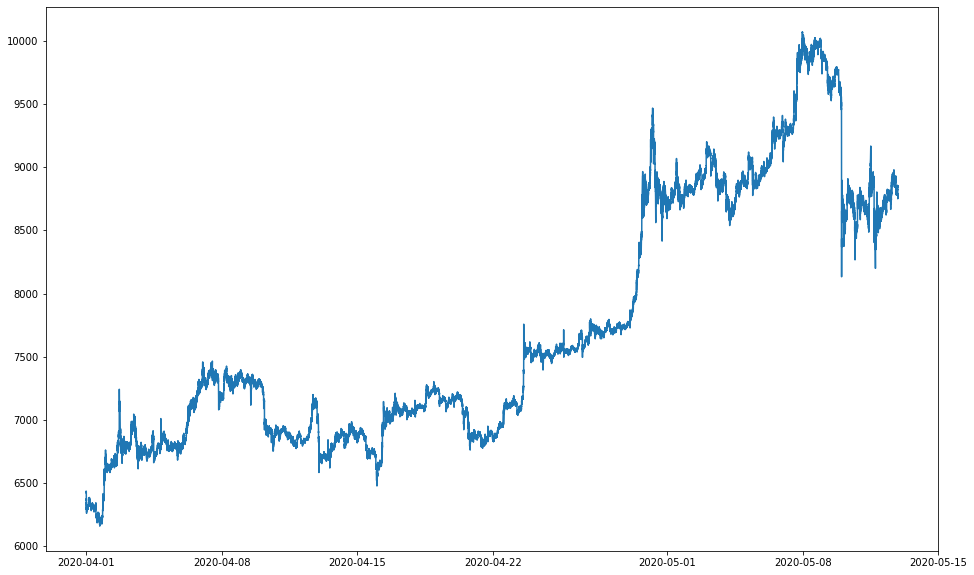

In [31]:
plt.plot(btc_index_dbit_df)

### Volatility index data

In [32]:
indices_df = pd.read_csv('/home/fp361/bitfear/vix-implementation/volatility_data.csv')
indices_df['timestamp'] = pd.to_datetime(indices_df['timestamp'])
indices_df = indices_df.set_index('timestamp').tz_localize('UTC', level=0)
indices_df

,vxbt,gvxbt,avxbt
timestamp,,,
2020-04-17 08:35:00+00:00,1.043923,0.796232,0.000114
2020-04-17 08:40:00+00:00,1.043290,0.796363,0.000114
2020-04-17 08:45:00+00:00,1.044881,0.791626,0.000113
2020-04-17 08:50:00+00:00,1.041748,0.799744,0.000114
2020-04-17 08:55:00+00:00,1.034267,0.803266,0.000115
...,...,...,...
2020-05-11 16:54:00+00:00,1.313524,1.172047,0.000138
2020-05-11 16:55:00+00:00,1.313623,1.172203,0.000138
2020-05-11 16:56:00+00:00,1.316412,1.171340,0.000138


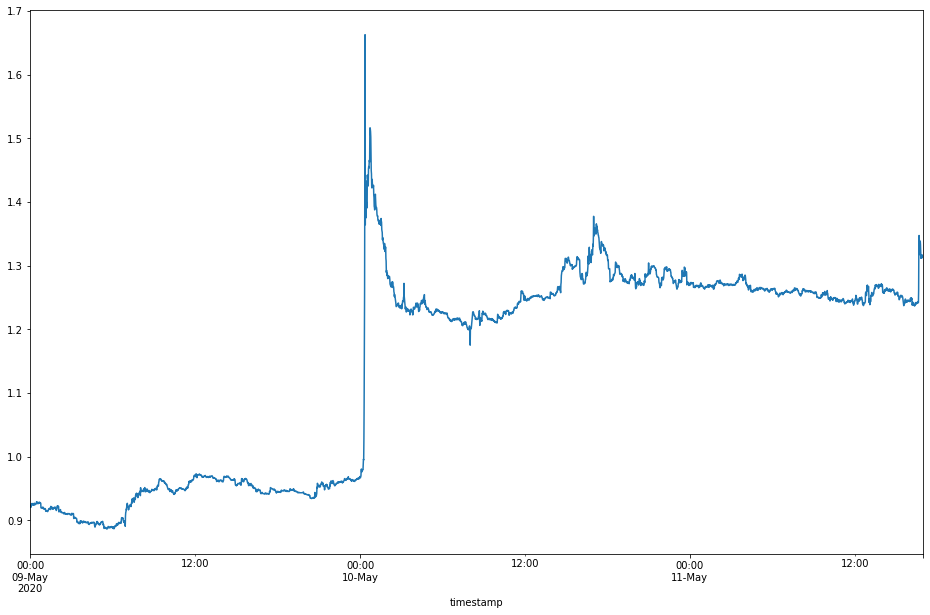

In [33]:
indices_df['vxbt'].loc['2020-05-09':].plot()

***

## Regression Models

### Data Cleaning

Select a common time range where each series has clean data available:

In [42]:
start_date = max([df.index[0] for df in [btc_index_dbit_df, sentiment_time, tweet_volume, indices_df]])#, gtrend_5min_df]])
end_date = min([df.index[-1] for df in [btc_index_dbit_df, sentiment_time, tweet_volume, indices_df]])#, gtrend_5min_df]])

print(f'Start: {start_date}')
print(f'End: {end_date}')

series_btc = btc_index_dbit_df.loc[start_date:end_date]
series_sentiment = sentiment_time['smooth'].loc[start_date:end_date]
series_volume = tweet_volume.filter(['smooth']).loc[start_date:end_date]
series_indices = indices_df['vxbt'].loc[start_date:end_date]
#series_gtrend = gtrend_5min_df['bitcoin'].loc[start_date:end_date]

Start: 2020-04-17 08:35:00+00:00
End: 2020-05-11 16:58:00+00:00


In [43]:
series_sentiment

created
2020-04-17 08:35:00+00:00    0.196330
2020-04-17 08:40:00+00:00    0.197086
2020-04-17 08:45:00+00:00    0.204792
2020-04-17 08:50:00+00:00    0.208757
2020-04-17 08:55:00+00:00    0.213473
                               ...   
2020-05-11 16:35:00+00:00    0.108305
2020-05-11 16:40:00+00:00    0.103183
2020-05-11 16:45:00+00:00    0.098067
2020-05-11 16:50:00+00:00    0.092976
2020-05-11 16:55:00+00:00    0.092678
Freq: 5T, Name: smooth, Length: 7013, dtype: float64

Plot narrowed down time series:

NameError: name 'series_gtrend' is not defined

/home/fp361/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


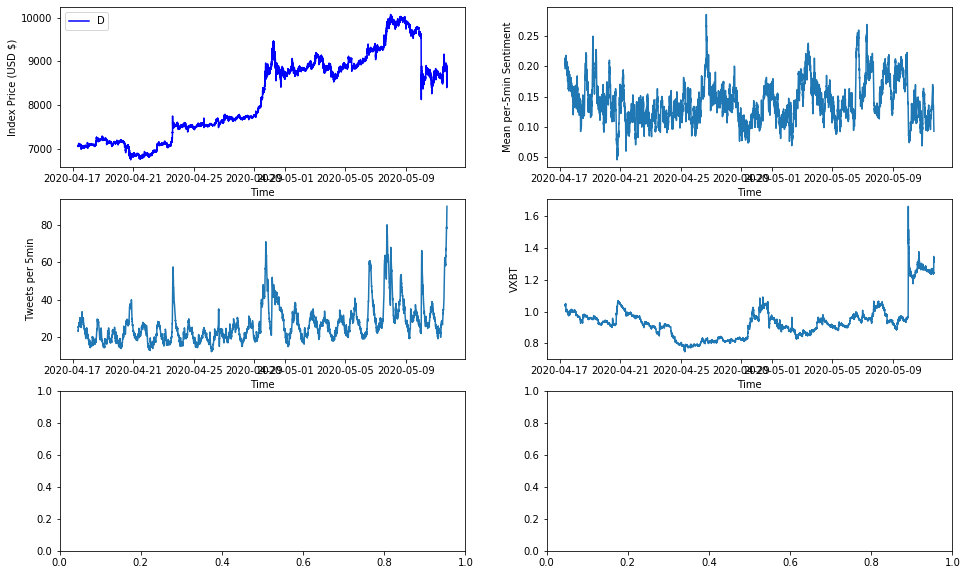

In [44]:
fig, ax =  plt.subplots(3,2)

ax[0][0].plot(series_btc, color='blue')
ax[0][0].legend('Deribit')
ax[0][0].set_xlabel('Time')
ax[0][0].set_ylabel('Index Price (USD $)')

ax[0][1].plot(series_sentiment)
ax[0][1].set_xlabel('Time')
ax[0][1].set_ylabel('Mean per-5min Sentiment')

ax[1][0].plot(series_volume)
ax[1][0].set_xlabel('Time')
ax[1][0].set_ylabel('Tweets per 5min')

ax[1][1].plot(series_indices)
ax[1][1].set_xlabel('Time')
ax[1][1].set_ylabel('VXBT')

ax[2][0].plot(series_gtrend)
ax[2][0].set_xlabel('Time')
ax[2][0].set_ylabel('Trend Value')

fig.suptitle('Time Series')

Discard Google Trends data for the time being. Need to determine what is causing the strange gaps.

In [45]:
#data = pd.DataFrame(series_indices).merge(series_volume, left_index=True, right_index=True).merge(series_sentiment, left_index=True, right_index=True).merge(series_gtrend, left_index=True, right_index=True).merge(series_btc, left_index=True, right_index=True).dropna()
data = pd.DataFrame(series_indices).merge(series_volume, left_index=True, right_index=True).merge(series_sentiment, left_index=True, right_index=True).merge(series_btc, left_index=True, right_index=True).dropna()
#data.columns = ['vxbt', 'tweet_vol', 'sentiment', 'gtrend', 'index']
data.columns = ['vxbt', 'tweet_vol', 'sentiment', 'index']
data = data.sort_index(ascending=False)
data

,vxbt,tweet_vol,sentiment,index
2020-05-11 16:55:00+00:00,1.313623,89.877338,0.092678,8615.21
2020-05-11 16:50:00+00:00,1.316462,88.950449,0.092976,8626.08
2020-05-11 16:45:00+00:00,1.333273,87.112987,0.098067,8555.02
2020-05-11 16:40:00+00:00,1.344772,85.955736,0.103183,8509.92
2020-05-11 16:35:00+00:00,1.241844,83.952047,0.108305,8850.93
...,...,...,...,...
2020-04-17 08:55:00+00:00,1.034267,23.174645,0.213473,7067.54
2020-04-17 08:50:00+00:00,1.041748,23.189199,0.208757,7064.75
2020-04-17 08:45:00+00:00,1.044881,23.121632,0.204792,7078.24
2020-04-17 08:40:00+00:00,1.043290,23.548435,0.197086,7075.52


In [46]:
# Backup in case of future kernel crash
data.to_csv('data.csv')

In [40]:
# Restore in case of kernel crash
data = pd.read_csv('data.csv')
data['timestamp'] = pd.to_datetime(data['Unnamed: 0'])
data = data.drop('Unnamed: 0', axis=1).set_index('timestamp')
data

,vxbt,tweet_vol,sentiment,index
timestamp,,,,
2020-05-11 16:55:00+00:00,1.313623,89.877338,0.092678,8615.21
2020-05-11 16:50:00+00:00,1.316462,88.950449,0.092976,8626.08
2020-05-11 16:45:00+00:00,1.333273,87.112987,0.098067,8555.02
2020-05-11 16:40:00+00:00,1.344772,85.955736,0.103183,8509.92
2020-05-11 16:35:00+00:00,1.241844,83.952047,0.108305,8850.93
...,...,...,...,...
2020-04-17 08:55:00+00:00,1.034267,23.174645,0.213473,7067.54
2020-04-17 08:50:00+00:00,1.041748,23.189199,0.208757,7064.75
2020-04-17 08:45:00+00:00,1.044881,23.121632,0.204792,7078.24


### Linear Regression

In [80]:
samples_in_window = 10
X = []
y = []

for i in range(1, data.shape[0] - samples_in_window):
    X.append(data.iloc[i:i + samples_in_window, :].to_numpy().ravel())
    
y = data['index'].iloc[0:data.shape[0] - samples_in_window - 1].to_numpy()

In [81]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()
linreg = linreg.fit(X, y)

In [82]:
print(linreg.intercept_)

feature_names = [f'{data.columns[i % len(data.columns)]},t-{i//len(data.columns)+1}' for i, coeff in enumerate(linreg.coef_)]
print(json.dumps(dict(zip(feature_names, linreg.coef_)), indent=1))

4.744703397109333
{
 "vxbt,t-1": -189.27584704249418,
 "tweet_vol,t-1": -0.5416707874264969,
 "sentiment,t-1": -21.313240867312643,
 "index,t-1": 1.0163825324174423,
 "vxbt,t-2": 617.706025986722,
 "tweet_vol,t-2": -0.21127071404699901,
 "sentiment,t-2": 71.16083774011129,
 "index,t-2": -0.02426584514059306,
 "vxbt,t-3": -407.87971298453357,
 "tweet_vol,t-3": 1.274877405118237,
 "sentiment,t-3": 37.00436490231652,
 "index,t-3": 0.02985357627138538,
 "vxbt,t-4": -68.1684623553495,
 "tweet_vol,t-4": -0.28694398850361563,
 "sentiment,t-4": -72.85374545321932,
 "index,t-4": -0.03851402732644755,
 "vxbt,t-5": 91.55302882540994,
 "tweet_vol,t-5": -0.16651948640825442,
 "sentiment,t-5": -17.469688122798527,
 "index,t-5": -0.006447980884538309,
 "vxbt,t-6": 153.56076622254173,
 "tweet_vol,t-6": -0.4263595827007643,
 "sentiment,t-6": -35.296518068252624,
 "index,t-6": -0.013625299724692877,
 "vxbt,t-7": -206.50891051458837,
 "tweet_vol,t-7": -0.24311581067550864,
 "sentiment,t-7": 80.6038302796

#### Metrics

In [83]:
from sklearn import metrics

output = pd.DataFrame(index=data.iloc[0:len(y)].index)
output['actual'] = data['index'].loc[:output.index[-1]]
output['predicted'] = linreg.predict(X)

print('RMSE {}'.format(np.sqrt(metrics.mean_squared_error(output['actual'], output['predicted']))))

RMSE 21.224050601899116


In [84]:
output

,actual,predicted
2020-05-11 16:55:00+00:00,8615.21,8622.613040
2020-05-11 16:50:00+00:00,8626.08,8606.158049
2020-05-11 16:45:00+00:00,8555.02,8485.005656
2020-05-11 16:40:00+00:00,8509.92,8839.895136
2020-05-11 16:35:00+00:00,8850.93,8885.698098
...,...,...
2020-04-17 09:50:00+00:00,7131.58,7122.908925
2020-04-17 09:45:00+00:00,7120.48,7120.229210
2020-04-17 09:40:00+00:00,7120.83,7117.285048
2020-04-17 09:35:00+00:00,7116.57,7090.345348


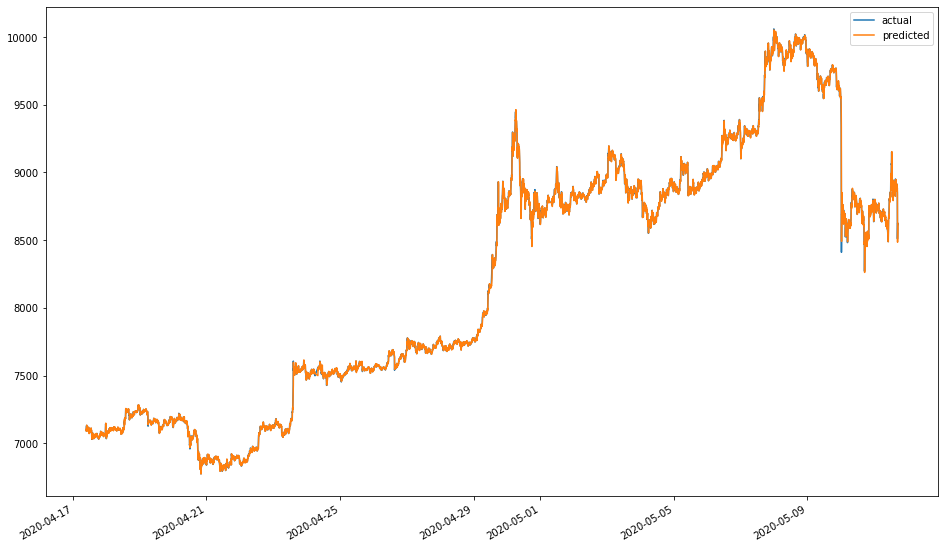

In [85]:
output.plot()

### Permutation Importance

In [86]:
from sklearn.inspection import permutation_importance

In [87]:
importances = permutation_importance(linreg, X, y)

importances_mean = dict(zip(feature_names, importances['importances_mean']))
sorted_im_mean = {k: v for k, v in sorted(importances_mean.items(), key=lambda item: item[1], reverse=True)}

print(json.dumps(sorted_im_mean, indent=1))

{
 "index,t-1": 2.0810066997489636,
 "index,t-7": 0.012426389486822864,
 "vxbt,t-2": 0.010837646914310018,
 "vxbt,t-3": 0.004702042758808411,
 "index,t-4": 0.0029923122358130215,
 "index,t-3": 0.0017957316010033032,
 "index,t-9": 0.001645264817083758,
 "vxbt,t-7": 0.0011960603206618626,
 "index,t-2": 0.00118715125791935,
 "vxbt,t-1": 0.0010119947802234685,
 "vxbt,t-6": 0.0006702410902858392,
 "tweet_vol,t-3": 0.00037961343779524537,
 "index,t-6": 0.0003748936784450319,
 "vxbt,t-5": 0.00023940112938001246,
 "tweet_vol,t-9": 0.0001487511439106415,
 "index,t-8": 0.00013546084569979744,
 "vxbt,t-4": 0.00012944102927510138,
 "index,t-5": 8.407045640497212e-05,
 "tweet_vol,t-10": 7.091510435048853e-05,
 "tweet_vol,t-1": 6.797985119861849e-05,
 "index,t-10": 6.078842694234865e-05,
 "vxbt,t-8": 5.56640103666739e-05,
 "tweet_vol,t-6": 4.104521627581459e-05,
 "tweet_vol,t-8": 3.1782526749002396e-05,
 "vxbt,t-9": 3.014972660506654e-05,
 "sentiment,t-9": 2.5063173735162535e-05,
 "tweet_vol,t-4": 1

## Predictive signals for VXBT

### Linear Regression

In [75]:
samples_in_window = 10
X_vxbt = []
y_vxbt = []

for i in range(1, data.shape[0] - samples_in_window):
    X_vxbt.append(data.iloc[i:i + samples_in_window, :].to_numpy().ravel())
    
y_vxbt = data['vxbt'].iloc[0:data.shape[0] - samples_in_window - 1].to_numpy()

In [76]:
linreg_vxbt = LinearRegression()
linreg_vxbt = linreg.fit(X_vxbt, y_vxbt)

print(linreg_vxbt.intercept_)

feature_names = [f'{data.columns[i % len(data.columns)]},t-{i//len(data.columns)+1}' for i, coeff in enumerate(linreg_vxbt.coef_)]
print(json.dumps(dict(zip(feature_names, linreg_vxbt.coef_)), indent=1))

0.00044978071381951423
{
 "vxbt,t-1": 1.1194705248670558,
 "tweet_vol,t-1": 0.0007575921018216507,
 "sentiment,t-1": -0.0015195532778870021,
 "index,t-1": -2.9073191720219643e-05,
 "vxbt,t-2": -0.14710434703214437,
 "tweet_vol,t-2": -0.0005535005907979119,
 "sentiment,t-2": -0.005070219178059517,
 "index,t-2": 3.596374729848203e-05,
 "vxbt,t-3": 0.09233783381644747,
 "tweet_vol,t-3": -0.0001932806344513094,
 "sentiment,t-3": -0.007713083506139859,
 "index,t-3": -1.1548285947295107e-05,
 "vxbt,t-4": -0.013149279456328928,
 "tweet_vol,t-4": -3.154397099513749e-05,
 "sentiment,t-4": 0.008574847230506916,
 "index,t-4": 4.3807415157783283e-07,
 "vxbt,t-5": -0.050341535377715914,
 "tweet_vol,t-5": 0.00010524541524890708,
 "sentiment,t-5": 0.006404200585610148,
 "index,t-5": -5.6068637392349054e-06,
 "vxbt,t-6": -0.11282399203643238,
 "tweet_vol,t-6": -3.9103034435635226e-05,
 "sentiment,t-6": -0.012395594943532243,
 "index,t-6": 1.4683158259515776e-05,
 "vxbt,t-7": 0.10395016608569935,
 "twe

#### Metrics

In [77]:
output_vxbt = pd.DataFrame(index=data.iloc[0:len(y_vxbt)].index)
output_vxbt['actual'] = data['vxbt'].loc[:output.index[-1]]
output_vxbt['predicted'] = linreg_vxbt.predict(X_vxbt)

print('RMSE {}'.format(np.sqrt(metrics.mean_squared_error(output_vxbt['actual'], output_vxbt['predicted']))))

RMSE 0.0053738336824225835


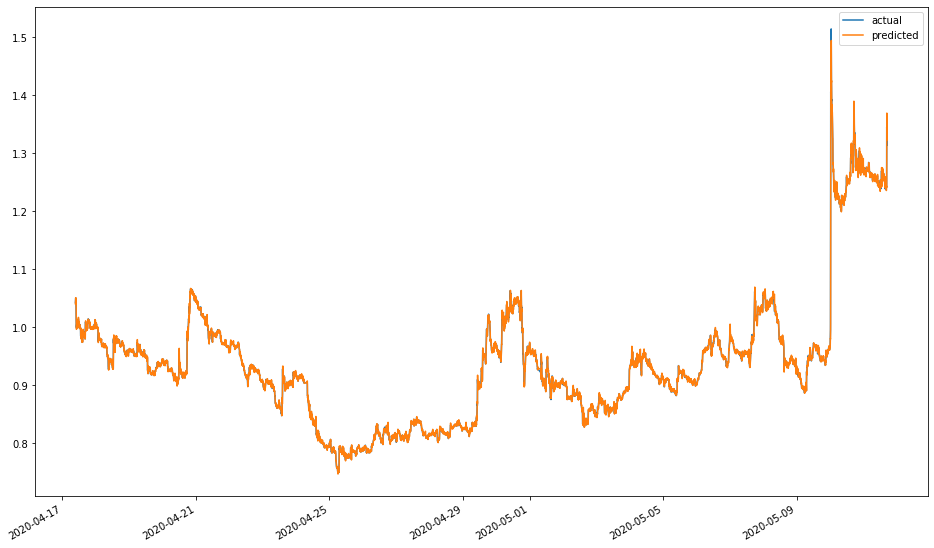

In [78]:
output_vxbt.plot()

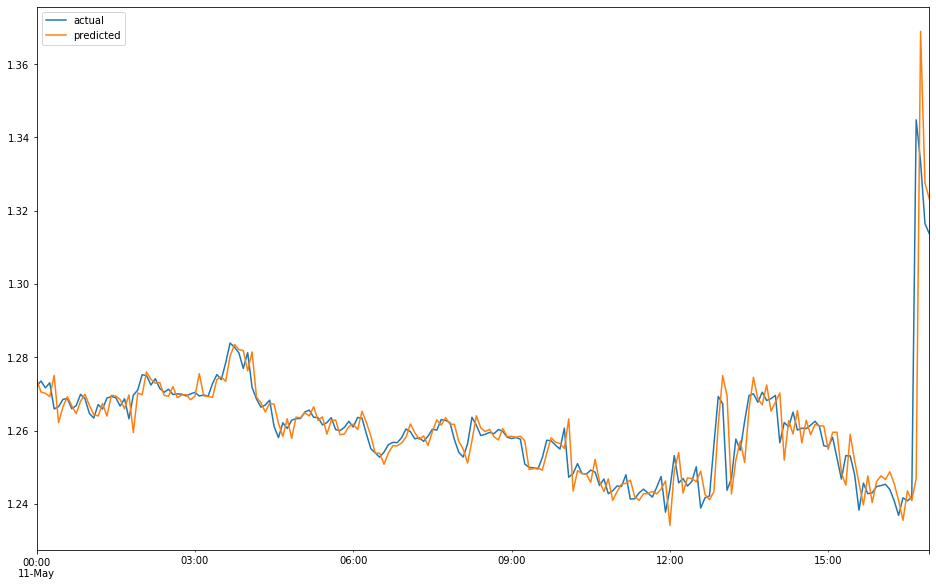

In [79]:
output_vxbt.loc[:'2020-05-11'].plot()

## Classification

### Predictive signals for VXBT

Assign each signal a direction for each time interval (http://users.auth.gr/passalis/assets/pdf/confs/2017_CBI_CNNLOB.pdf)

In [52]:
norm_data = (data-data.min())/(data.max()-data.min())
norm_data['vxbt_prev'] = norm_data['vxbt'].shift(-1)
norm_data['tweet_vol_prev'] = norm_data['tweet_vol'].shift(-1)
norm_data['sentiment_prev'] = norm_data['sentiment'].shift(-1)
norm_data['index_prev'] = norm_data['index'].shift(-1)
norm_data

,vxbt,tweet_vol,sentiment,index,vxbt_prev,tweet_vol_prev,sentiment_prev,index_prev
timestamp,,,,,,,,
2020-05-11 16:55:00+00:00,0.738434,1.000000,0.196436,0.560410,0.742140,0.988073,0.197677,0.563718
2020-05-11 16:50:00+00:00,0.742140,0.988073,0.197677,0.563718,0.764085,0.964429,0.218911,0.542096
2020-05-11 16:45:00+00:00,0.764085,0.964429,0.218911,0.542096,0.779097,0.949537,0.240243,0.528373
2020-05-11 16:40:00+00:00,0.779097,0.949537,0.240243,0.528373,0.644731,0.923754,0.261606,0.632135
2020-05-11 16:35:00+00:00,0.644731,0.923754,0.261606,0.632135,0.643378,0.885099,0.295882,0.643336
...,...,...,...,...,...,...,...,...
2020-04-17 08:55:00+00:00,0.373752,0.141674,0.700195,0.089486,0.383518,0.141862,0.680527,0.088637
2020-04-17 08:50:00+00:00,0.383518,0.141862,0.680527,0.088637,0.387608,0.140992,0.663993,0.092741
2020-04-17 08:45:00+00:00,0.387608,0.140992,0.663993,0.092741,0.385531,0.146484,0.631855,0.091914


In [104]:
def assign_vxbt_direction(row, threshold):
    if row.vxbt_prev > row.vxbt + threshold:
        return 1
    elif row.vxbt_prev < row.vxbt - threshold:
        return -1
    else:
        return 0

def assign_direction(row, threshold):
    if row[1] > row[0] * (1 + threshold):
        return 1
    elif row[1] < row[0] * (1 - threshold):
        return -1
    else:
        return 0
    
norm_data['vxbt_direction'] = norm_data[['vxbt', 'vxbt_prev']].apply(assign_vxbt_direction, axis=1, threshold=0.01)
norm_data['tweet_vol_direction'] = norm_data[['tweet_vol', 'tweet_vol_prev']].apply(assign_direction, axis=1, threshold=0.01)
norm_data['sentiment_direction'] = norm_data[['sentiment', 'sentiment_prev']].apply(assign_direction, axis=1, threshold=0.01)
norm_data['index_direction'] = norm_data[['index', 'index_prev']].apply(assign_direction, axis=1, threshold=0.01)

direction_df = norm_data.copy().filter(['vxbt_direction', 'tweet_vol_direction', 'sentiment_direction', 'index_direction'])
direction_df

,vxbt_direction,tweet_vol_direction,sentiment_direction,index_direction
timestamp,,,,
2020-05-11 16:55:00+00:00,0,-1,0,0
2020-05-11 16:50:00+00:00,1,-1,1,-1
2020-05-11 16:45:00+00:00,1,-1,1,-1
2020-05-11 16:40:00+00:00,-1,-1,1,1
2020-05-11 16:35:00+00:00,0,-1,1,1
...,...,...,...,...
2020-04-17 08:55:00+00:00,0,0,-1,0
2020-04-17 08:50:00+00:00,0,0,-1,1
2020-04-17 08:45:00+00:00,0,1,-1,0


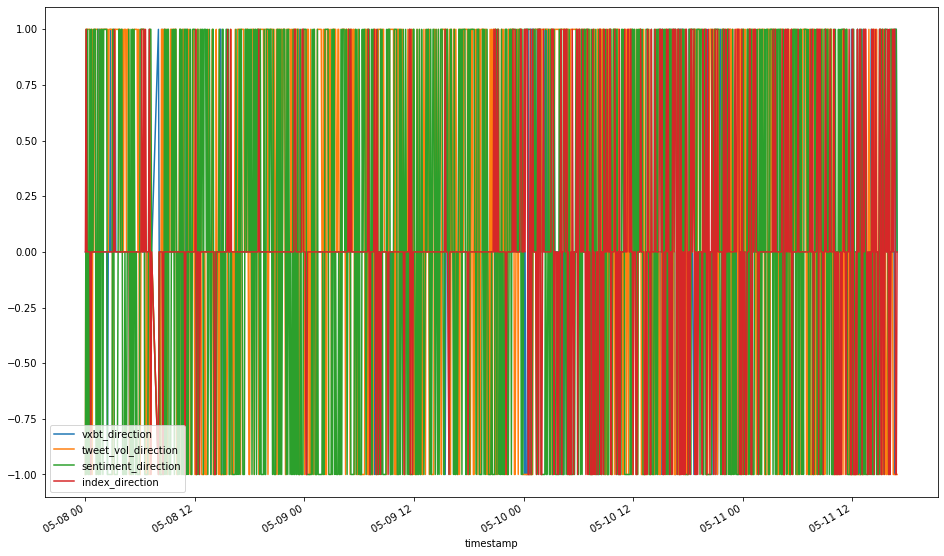

In [105]:
direction_df.loc[:'2020-05-08'].plot()

Backup in case of future kernel crash

In [57]:
direction_df.to_csv('direction.csv', index=False)

#### Logistic Regression

In [102]:
from sklearn.linear_model import LogisticRegression

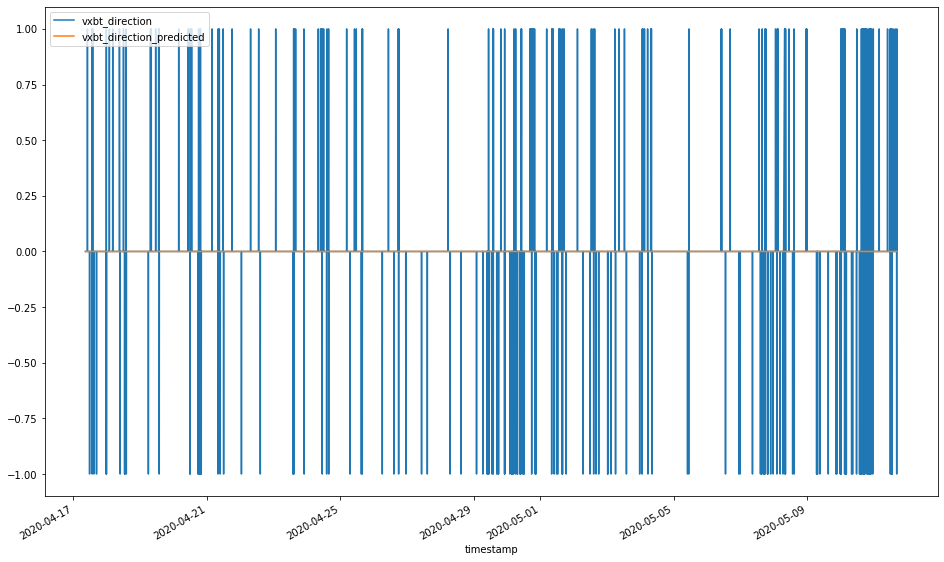

In [109]:
X = direction_df[['tweet_vol_direction', 'sentiment_direction', 'index_direction']].iloc[1:]
y = direction_df['vxbt_direction'].shift(1).dropna()

logreg = LogisticRegression().fit(X, y)

direction_df['vxbt_direction_predicted'] = np.append(logreg.predict(X), np.nan)
direction_df[['vxbt_direction', 'vxbt_direction_predicted']].plot()

#### Gradient Boosting Classifier

In [89]:
from sklearn.ensemble import GradientBoostingClassifier

In [92]:
gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0).fit(X, y)

sum(gbc.predict(X))

0.0